In [1]:
import pandas as pd
import numpy as np

import geopandas as gp
from shapely.geometry import Point
import rasterio as rio
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
# load data
cust = pd.read_csv('data/customer_profiles_inputs.csv')
cust = cust.rename({'High.Repayors': 'High Repayors'}, axis=1)
del cust['X']
del cust['solar']
cust = cust.loc[:, ~cust.columns.str.contains('^Unnamed')]

# shapefile
kenya = gp.read_file("data/boundaries/KEN_adm0.shp")

Text(0.5, 0.98, 'Proportion of high repayors by location')

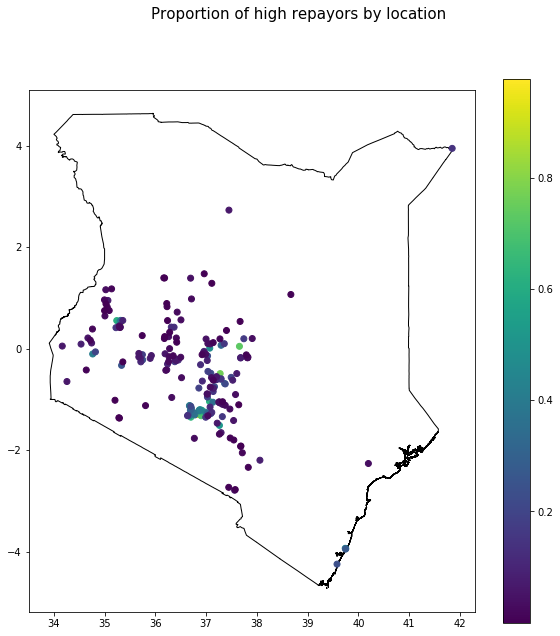

In [3]:
# visualize data
cust_sp = cust
cust_sp['coordinates'] = cust_sp[['long', 'lat']].values.tolist()
cust_sp['coordinates'] = cust_sp['coordinates'].apply(Point)
cust_sp = gp.GeoDataFrame(cust_sp, geometry='coordinates',crs={'init' :'epsg:4326'})
fig, ax = plt.subplots(1, 1, figsize=(10,10))
base = kenya.plot(ax=ax, color='white', edgecolor='black')
cust_sp.plot(ax=base, column='High Repayors',legend=True)
fig.suptitle("Proportion of high repayors by location", fontsize=15)

Text(0.5, 0, 'Proportion of high repayors')

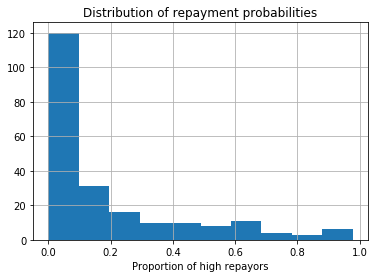

In [4]:
# distribution of high repayors
cust['High Repayors'].hist()
plt.title('Distribution of repayment probabilities')
plt.xlabel('Proportion of high repayors')

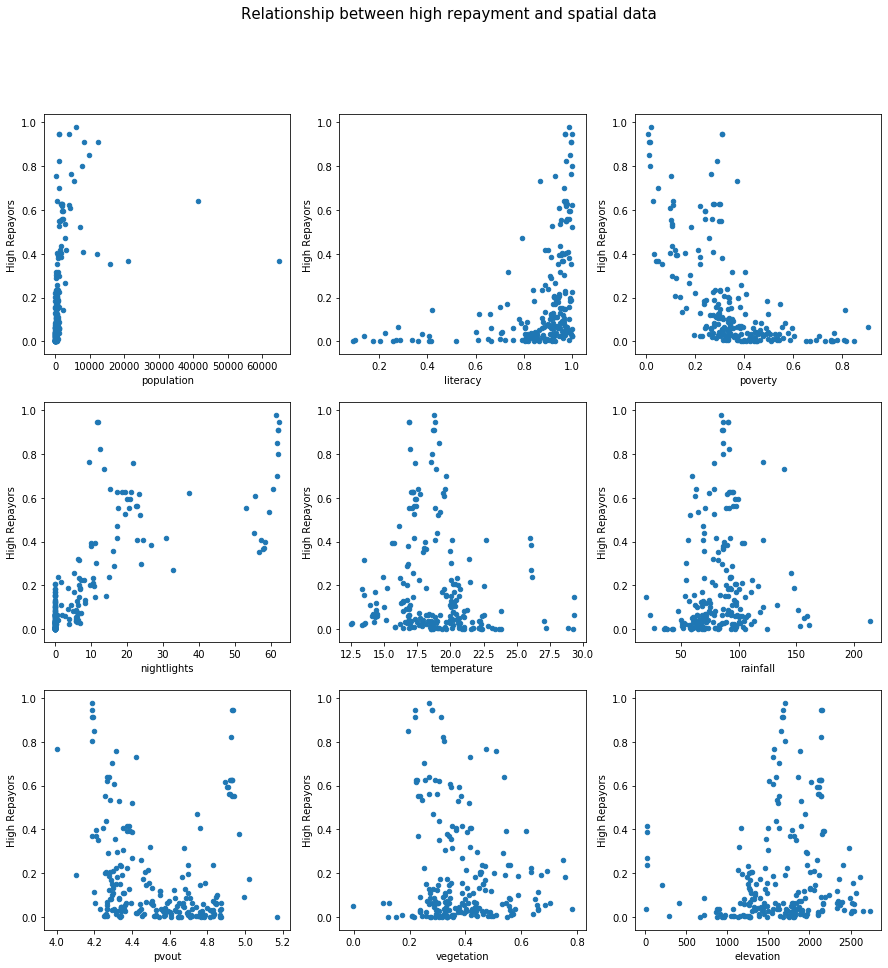

In [5]:
# visualize relationship between high repayment and features
fig, ax = plt.subplots(3, 3, figsize=(15,15))
fig.suptitle("Relationship between high repayment and spatial data", fontsize=15)

cust.plot.scatter('population','High Repayors',ax = ax[0][0])
cust.plot.scatter('literacy','High Repayors',ax = ax[0][1])
cust.plot.scatter('poverty','High Repayors',ax = ax[0][2])
cust.plot.scatter('nightlights','High Repayors',ax = ax[1][0])
cust.plot.scatter('temperature','High Repayors',ax = ax[1][1])
cust.plot.scatter('rainfall','High Repayors',ax = ax[1][2])
cust.plot.scatter('pvout','High Repayors',ax = ax[2][0])
cust.plot.scatter('vegetation','High Repayors',ax = ax[2][1])
cust.plot.scatter('elevation','High Repayors',ax = ax[2][2])

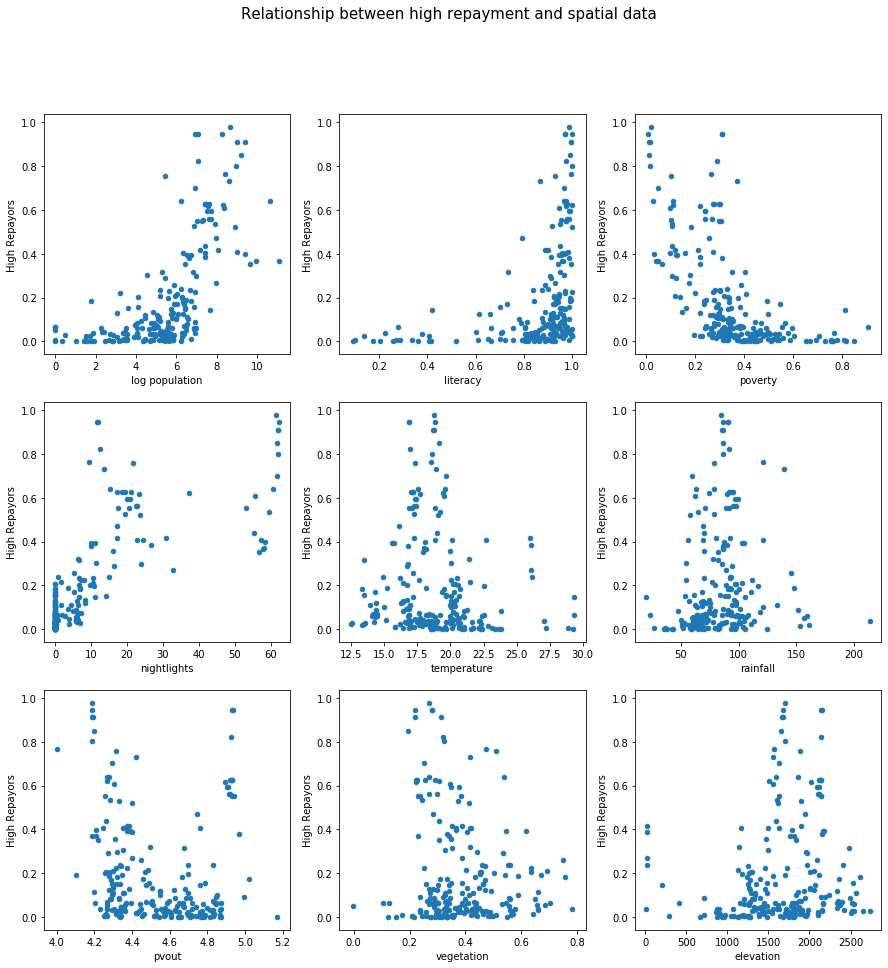

In [6]:
# convert population to log population
cust['population'] = np.log(cust['population'])
cust.loc[cust['population']<0,'population'] = 0

fig, ax = plt.subplots(3, 3, figsize=(15,15))
fig.suptitle("Relationship between high repayment and spatial data", fontsize=15)

cust.plot.scatter('population','High Repayors',ax = ax[0][0])
ax[0][0].set_xlabel("log population")
cust.plot.scatter('literacy','High Repayors',ax = ax[0][1])
cust.plot.scatter('poverty','High Repayors',ax = ax[0][2])
cust.plot.scatter('nightlights','High Repayors',ax = ax[1][0])
cust.plot.scatter('temperature','High Repayors',ax = ax[1][1])
cust.plot.scatter('rainfall','High Repayors',ax = ax[1][2])
cust.plot.scatter('pvout','High Repayors',ax = ax[2][0])
cust.plot.scatter('vegetation','High Repayors',ax = ax[2][1])
cust.plot.scatter('elevation','High Repayors',ax = ax[2][2])

In [7]:
# create feature and label arrays
feature_list = ['population','literacy','poverty','nightlights','temperature','rainfall','pvout','vegetation','elevation']
X = cust[['population','literacy','poverty','nightlights','temperature','rainfall','pvout','vegetation','elevation']].to_numpy()
y = cust['High Repayors'].to_numpy()

# OLS (on all data)

In [8]:
# simple ols model
X_ols = sm.add_constant(cust[['population','literacy','poverty','nightlights','temperature','rainfall','pvout','vegetation','elevation']])
sm.OLS(cust['High Repayors'],X_ols).fit().summary()

C:\Anaconda\envs\Fraym\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          High Repayors   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     49.81
Date:                Mon, 09 Sep 2019   Prob (F-statistic):           2.87e-47
Time:                        21:28:54   Log-Likelihood:                 125.78
No. Observations:                 219   AIC:                            -231.6
Df Residuals:                     209   BIC:                            -197.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.3788      0.439     -3.139      0.002      -2.245      -0.513
population      0.0279      0.008      3.448      0.001       0.012       0.044
literacy       -0.0158      0.103     -0.153      0.879      -0.220       0.188
poverty        -0.3072      0.157     -1.956      0.052      -0.617       0.002
nightlights     0.0076      0.001      6.628      0.000       0.005       0.010
temperature     0.0269      0.014      1.929      0.055      -0.001       0.054
rainfall        0.0005      0.001      0.914      0.362      -0.001       0.002
pvout           0.1609      0.059      2.745      0.007       0.045       0.276
vegetation     -0.1329      0.112     -1.190      0.236      -0.353       0.087
elevation       0.0001   7.92e-05      1.848      0.066   -9.75e-06       0.000
==============================================================================
Omnibus:                       67.816   Durbin-Watson:                   1.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              253.878
Skew:                           1.212   Prob(JB):                     7.43e-56
Kurtosis:                       7.685   Cond. No.                     8.17e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Beta regression (on all data)

In [9]:
# beta regression model (as labels are proportions)
X_beta = sm.add_constant(cust[['population','literacy','poverty','nightlights','temperature','rainfall','pvout','vegetation','elevation']])
binom_glm = sm.GLM(cust['High Repayors'], X_beta, family=sm.families.Binomial())
binom_glm.fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM              AIC:            139.0409  
Link Function:      logit            BIC:            -1102.0008
Dependent Variable: High Repayors    Log-Likelihood: -59.520   
Date:               2019-09-09 21:28 LL-Null:        -86.177   
No. Observations:   219              Deviance:       24.315    
Df Model:           9                Pearson chi2:   28.7      
Df Residuals:       209              Scale:          1.0000    
Method:             IRLS                                       
---------------------------------------------------------------
                Coef.   Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
const          -13.3463  10.3741 -1.2865 0.1983 -33.6792 6.9866
population       0.3127   0.2146  1.4571 0.1451  -0.1079 0.7332
literacy         0.7231   3.5171  0.2056 0.8371  -6.1703 7.6165
poverty         -5.3449   4.0475 -1.3205 0.1867 -13.2779 2.5881
nightlights      0.0122   0.0266  0.4601 0.6454  -0.0399 0.0643
temperature      0.1332   0.4176  0.3191 0.7497  -0.6852 0.9517
rainfall         0.0055   0.0140  0.3926 0.6946  -0.0219 0.0329
pvout            1.5752   1.2586  1.2516 0.2107  -0.8915 4.0419
vegetation      -0.8671   2.6509 -0.3271 0.7436  -6.0628 4.3285
elevation        0.0006   0.0022  0.2759 0.7826  -0.0037 0.0049
===============================================================

"""

# Data preparation for prediction

In [10]:
# split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (164, 9)
Training Labels Shape: (164,)
Testing Features Shape: (55, 9)
Testing Labels Shape: (55,)


In [11]:
# standardize features
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):

    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, model.predict(X_test))
    rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

    print('R2 train: ', round(r2_train,4))    
    print('R2 test: ', round(r2_test,4))
    print('RMSE train: ', round(rmse_train,4))
    print('RMSE test: ', round(rmse_test,4))

# Linear regression

In [13]:
# simple linear regression model
lm = LinearRegression()
lm.fit(X_train, y_train)
evaluate_model(lm, X_train, y_train, X_test, y_test)

R2 train:  0.7513
R2 test:  0.4768
RMSE train:  0.1185
RMSE test:  0.1828


# Linear regression with polynomial features 

In [14]:
# 2nd degree polynomial features
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X)
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size = 0.30, random_state = 0)
lm_poly = LinearRegression().fit(X_train_poly, y_train_poly)
evaluate_model(lm_poly, X_train_poly, y_train_poly, X_test_poly, y_test_poly)

R2 train:  0.8971
R2 test:  0.7087
RMSE train:  0.076
RMSE test:  0.1362


# Support Vector Regression

In [15]:
# svr with rbf kernel
svr_model = SVR(kernel = "rbf", C = 1e4, gamma = 1e-5, epsilon = 0.1)
svr_model.fit(X_train,y_train)
evaluate_model(svr_model, X_train, y_train, X_test, y_test)

R2 train:  0.7482
R2 test:  0.4761
RMSE train:  0.1193
RMSE test:  0.1829


# Random Forest

In [16]:
# basic rf model
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)
rf.fit(X_train, y_train)
evaluate_model(rf, X_train, y_train, X_test, y_test)

R2 train:  0.9823
R2 test:  0.7825
RMSE train:  0.0317
RMSE test:  0.1179


In [17]:
# feature importance
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True) 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: nightlights          Importance: 0.8
Variable: population           Importance: 0.04
Variable: pvout                Importance: 0.04
Variable: poverty              Importance: 0.03
Variable: temperature          Importance: 0.03
Variable: literacy             Importance: 0.02
Variable: rainfall             Importance: 0.01
Variable: vegetation           Importance: 0.01
Variable: elevation            Importance: 0.01


[None, None, None, None, None, None, None, None, None]

In [18]:
# depth of a random tree
rf.estimators_[5].tree_.max_depth

15

# Smaller tree

In [19]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=1000, max_depth = 3)
rf_small.fit(X_train, y_train)
evaluate_model(rf_small, X_train, y_train, X_test, y_test)

R2 train:  0.9216
R2 test:  0.73
RMSE train:  0.0666
RMSE test:  0.1313


In [20]:
# feature importance in small tree
importances = list(rf_small.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: nightlights          Importance: 0.85
Variable: population           Importance: 0.05
Variable: poverty              Importance: 0.03
Variable: pvout                Importance: 0.03
Variable: temperature          Importance: 0.02
Variable: literacy             Importance: 0.01
Variable: vegetation           Importance: 0.01
Variable: elevation            Importance: 0.01
Variable: rainfall             Importance: 0.0


[None, None, None, None, None, None, None, None, None]

# Cross validation for hyperparameter tuning

In [21]:
# choosing over a random grid first
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 3000, num = 10)]
max_features = ['auto', 'log2']
max_depth = [int(x) for x in np.linspace(5, 15, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [22]:
# 100 random iterations
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.0min finished
C:\Anaconda\envs\Fraym\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [23]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 12,
 'bootstrap': False}

In [24]:
best_random = rf_random.best_estimator_
evaluate_model(best_random, X_train, y_train, X_test, y_test)

R2 train:  0.9948
R2 test:  0.8204
RMSE train:  0.0171
RMSE test:  0.1071


In [25]:
importances = list(best_random.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: nightlights          Importance: 0.4
Variable: population           Importance: 0.23
Variable: poverty              Importance: 0.15
Variable: pvout                Importance: 0.09
Variable: literacy             Importance: 0.04
Variable: temperature          Importance: 0.03
Variable: elevation            Importance: 0.03
Variable: rainfall             Importance: 0.02
Variable: vegetation           Importance: 0.02


[None, None, None, None, None, None, None, None, None]

In [26]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [6, 9, 12],
    'max_features': ['log2'],
    'n_estimators': [500, 1000, 1500]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [27]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   19.6s finished
C:\Anaconda\envs\Fraym\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': False,
 'max_depth': 9,
 'max_features': 'log2',
 'n_estimators': 1500}

In [28]:
best_grid = grid_search.best_estimator_
evaluate_model(best_grid, X_train, y_train, X_test, y_test)

R2 train:  0.9991
R2 test:  0.8318
RMSE train:  0.0072
RMSE test:  0.1036


In [29]:
importances = list(best_grid.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: nightlights          Importance: 0.39
Variable: population           Importance: 0.24
Variable: poverty              Importance: 0.16
Variable: pvout                Importance: 0.08
Variable: literacy             Importance: 0.04
Variable: temperature          Importance: 0.03
Variable: elevation            Importance: 0.03
Variable: rainfall             Importance: 0.02
Variable: vegetation           Importance: 0.02


[None, None, None, None, None, None, None, None, None]

# Random Forest with fewer variables

In [30]:
rf_imp = RandomForestRegressor(n_estimators= 2000, max_features='log2', bootstrap=False)
important_indices = [feature_list.index('nightlights'), feature_list.index('population'), feature_list.index('poverty'), feature_list.index('pvout')]
X_train_imp = X_train[:, important_indices]
X_test_imp = X_test[:, important_indices]

rf_imp.fit(X_train_imp, y_train)
evaluate_model(rf_imp, X_train_imp, y_train, X_test_imp, y_test)

R2 train:  1.0
R2 test:  0.8339
RMSE train:  0.0
RMSE test:  0.103


In [31]:
rf_imp.estimators_[5].tree_.max_depth

18

In [32]:
feature_list = ['nightlights','population','poverty','pvout']
importances = list(rf_imp.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: nightlights          Importance: 0.51
Variable: population           Importance: 0.26
Variable: poverty              Importance: 0.17
Variable: pvout                Importance: 0.06


[None, None, None, None]

# Random Forest with polynomial features

In [33]:
rf = RandomForestRegressor(n_estimators = 2000, max_features='log2', bootstrap=False)
rf.fit(X_train_poly, y_train_poly)
evaluate_model(rf, X_train_poly, y_train_poly, X_test_poly, y_test_poly)

R2 train:  1.0
R2 test:  0.8342
RMSE train:  0.0
RMSE test:  0.1027


In [34]:
rf.estimators_[5].tree_.max_depth

13

# Insights for Solar Company

Text(0.7, 4.6, '70% high repayors')

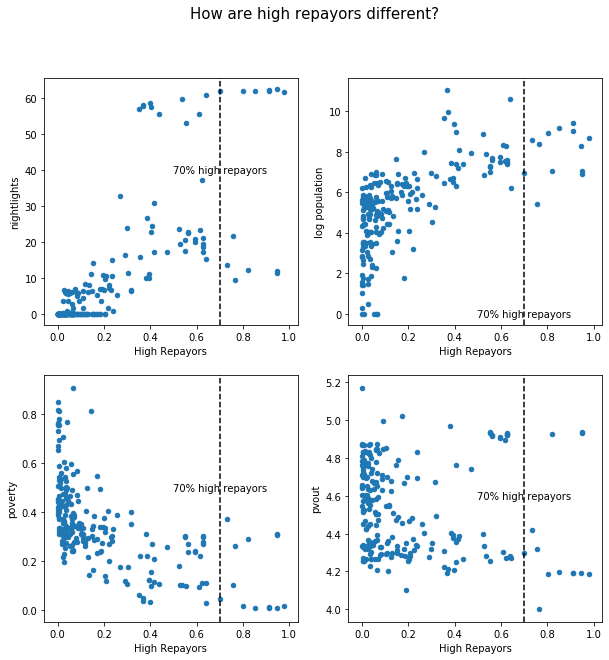

In [35]:
# visualizing difference between high and low repaying clusters
fig, ax = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle("How are high repayors different?", fontsize=15)

cust.plot.scatter('High Repayors','nightlights',ax = ax[0][0])
ax[0][0].axvline(x=0.7, color='k', linestyle='--')
ax[0][0].text(0.7, 40, "70% high repayors", ha='center', va='center',fontsize=10)

cust.plot.scatter('High Repayors','population',ax = ax[0][1])
ax[0][1].set_ylabel("log population")
ax[0][1].axvline(x=0.7, color='k', linestyle='--')
ax[0][1].text(0.7, 0, "70% high repayors", ha='center', va='center',fontsize=10)

cust.plot.scatter('High Repayors','poverty',ax = ax[1][0])
ax[1][0].axvline(x=0.7, color='k', linestyle='--')
ax[1][0].text(0.7, 0.5, "70% high repayors", ha='center', va='center',fontsize=10)

cust.plot.scatter('High Repayors','pvout',ax = ax[1][1])
ax[1][1].axvline(x=0.7, color='k', linestyle='--')
ax[1][1].text(0.7, 4.6, "70% high repayors", ha='center', va='center',fontsize=10)

In [36]:
high = cust[cust['High Repayors']>=0.7]
low = cust[cust['High Repayors']<0.7]

In [37]:
high[['nightlights','population','poverty','pvout']].mean()

nightlights    39.574547
population      7.993815
poverty         0.135681
pvout           4.382736
dtype: float64

In [38]:
low[['nightlights','population','poverty','pvout']].mean()

nightlights    7.031015
population     5.248777
poverty        0.360352
pvout          4.538289
dtype: float64

# Raster of repayment probabilities (0.00833 x 0.00833 degrees)

In [41]:
# load kenya raster stack and corresponding dataframe
kenya_df = pd.read_csv('data/kenya_df.csv')
kenya_df.rename( columns={'Unnamed: 0':'pixel', 'x':'long','y':'lat','KEN_popmap15adj_v2b':'population', \
                         'KEN_literacy_F':'literacy', 'ken08povmpi':'poverty', \
                         'F182013.v4c_web.stable_lights.avg_vis':'nightlights', 'index_1.1':'temperature', \
                         'index_1.2':'rainfall', 'PVOUT':'pvout', 'layer.1':'vegetation', \
                         'layer.2':'elevation'}, inplace=True)
kenya_df = kenya_df.dropna(subset=['population','literacy','poverty','nightlights','temperature','rainfall','pvout',\
                                   'vegetation','elevation'])
kenya_df = kenya_df.reset_index(drop=True)
kenya_df.loc[kenya_df['population']==0,'population'] = 1
kenya_df['population'] = np.log(kenya_df['population'])
kenya_df.loc[kenya_df['population']<0,'population'] = 0

kenya_stack = rio.open('data/kenya_stack.tif')

In [42]:
# data preparation for prediction
X_pred = kenya_df[['population','literacy','poverty','nightlights','temperature','rainfall','pvout','vegetation','elevation']].to_numpy()
X_pred = scaler.transform(X_pred)
X_pred_imp = X_pred[:, important_indices]

In [43]:
# prediction using best_grid model and rf_imp model
y_pred = best_grid.predict(X_pred)
y_pred_imp = rf_imp.predict(X_pred_imp)

In [44]:
# preparation of predictions dataframe and spatial dataframe
kenya_pred_df = kenya_df[['pixel','long','lat']]
kenya_pred_df = kenya_pred_df.assign(y_pred=pd.Series(y_pred).values)
kenya_pred_df = kenya_pred_df.assign(y_pred_imp=pd.Series(y_pred_imp).values)

geometry = [Point(xy) for xy in zip(kenya_pred_df.iloc[:, 1], kenya_pred_df.iloc[:, 2])]
kenya_pred_sp = gp.GeoDataFrame(kenya_pred_df, geometry=geometry)

Text(0.5, 0.98, 'Predicted high repayment probabilities')

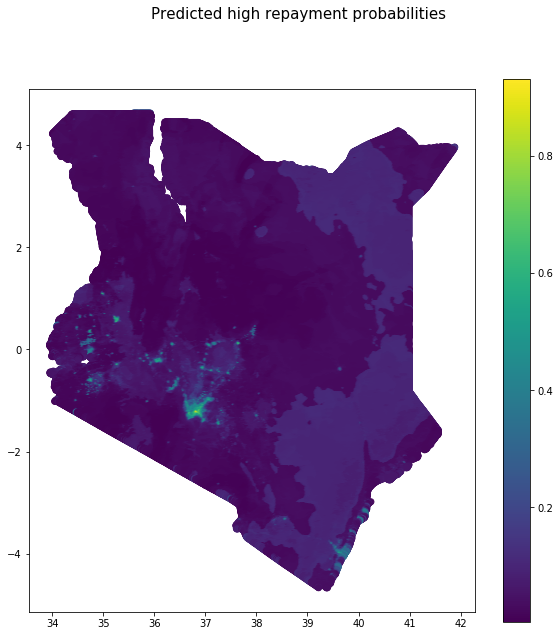

In [45]:
# visualize high repayment raster obtained using best_grid
fig, ax = plt.subplots(1, 1, figsize=(10,10))
kenya_pred_sp.plot(ax=ax,column='y_pred',legend=True)
fig.suptitle("Predicted high repayment probabilities", fontsize=15)

Text(0.5, 0.98, 'Predicted high repayment probabilities')

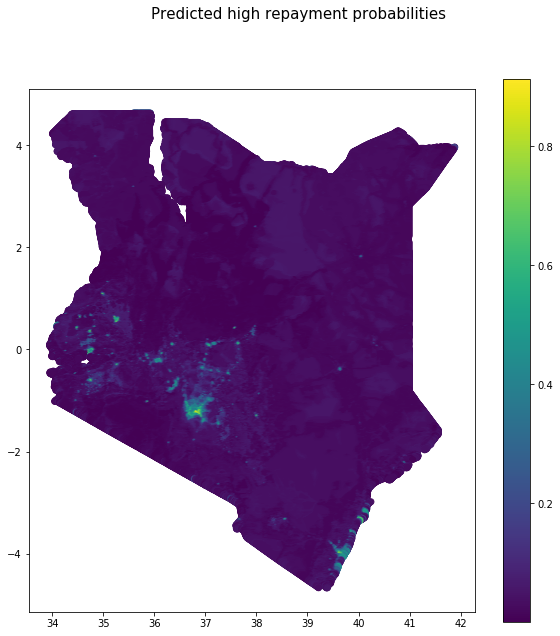

In [46]:
# visualize high repayment raster obtained using rf_imp
fig, ax = plt.subplots(1, 1, figsize=(10,10))
kenya_pred_sp.plot(ax=ax,column='y_pred_imp',legend=True)
fig.suptitle("Predicted high repayment probabilities", fontsize=15)

In [47]:
# potential locations for Solar4u
kenya_pred_df[kenya_pred_df['y_pred']>=0.7][['long','lat','y_pred']]

,long,lat,y_pred
325619,35.225056,0.566724,0.704051
331369,35.308386,0.508393,0.764709
378366,37.658292,0.041745,0.716205
504665,36.874990,-1.249870,0.720635
505479,36.866657,-1.258203,0.729975
505480,36.874990,-1.258203,0.744867
505481,36.883323,-1.258203,0.753445
505482,36.891656,-1.258203,0.759738
506287,36.808326,-1.266536,0.702799
506288,36.816659,-1.266536,0.809649


In [48]:
# write to csv
kenya_pred_df = kenya_pred_df[['long','lat','y_pred']]
kenya_pred_df.to_csv("data/kenya_pred.csv",index=False)